In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs  
from matplotlib import ticker, cm

import aeolus
from aeolus.calc.stats import cumsum, spatial
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels
from aeolus.const import init_const
pcb_const=init_const('proxb')




In [2]:
warnings.filterwarnings("ignore")


# Import the data

In [6]:
pcb_32 = iris.load('../../eccent_paper/data/pcb_32_fix_17120_120.nc')

In [12]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_32)

# Functions for statistics, slicing

In [8]:

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume


def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

def height_to_pressure(cube, pressurecube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 



# Requirements for lifetime calculations

In [9]:
k_b = 1.38e-23 #J/K
g = pcb_const.gravity.data #m/s2
m_air = 28.964*(1.66e-27) #kg

In [10]:
def vmr_molec(cube, p_cube, t_cube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = p_cube.interpolate(height, iris.analysis.Linear())
    volume = volume_weights_cube2(cube)
    nair=(p_reg*volume)/((1.38*10**(-23))*t_cube) #nair in molec/gridbox
    cube_molec = cube*nair/volume #n_o3 in molec/m3
    cube_molec *= 1e-6
    return cube_molec
def rflux_molec(cube):
    volume = volume_weights_cube2(cube)
    cube_molec = cube*(6.022e23)/volume
    return cube_molec

def dtyn_vert(zwind):##in years
    vert_height=zwind[1:].coord('level_height').points-zwind[0:60].coord('level_height').points
    tdyn_vert_inv=(zwind[1:]/vert_height)
    tdyn_vert=1/tdyn_vert_inv
    return tdyn_vert

def scale_height(temp):
    H = k_b*temp/(m_air*g)
    return H
def selected_slice_mean(cube,lat_l,lat_u,lon_l,lon_u):
    cube2 = cube[:,lat_l:lat_u,lon_l:lon_u]
    cube2 = zonal_mean(meridional_mean(cube2))
    return cube2

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Figure 8: chemical and dynamical lifetimes at distinct locations in planetary atmosphere

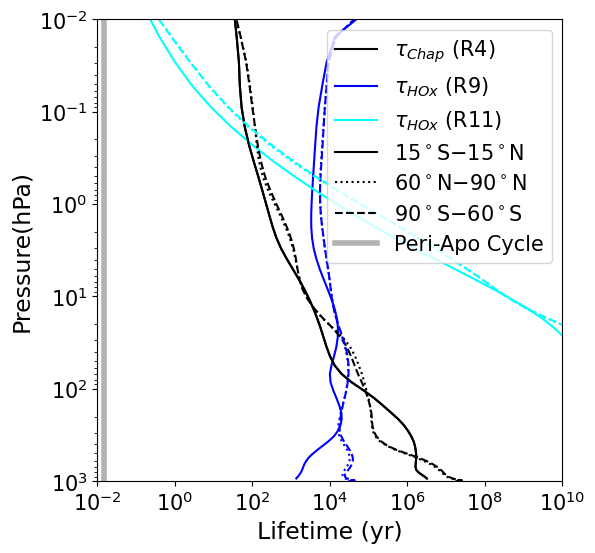

In [19]:
def lifetimes(cubelist, lname_mol='O3 MASS MIXING RATIO', m_mol=48, time_slice_l=0,
                                              time_slice_u=120,sublabel=False, sublabel_t='a', 
                                 const=None, save=False, model=aeolus.model.um):
    for cube in cubelist:
        if cube.standard_name == 'eastward_wind':
            u = cube[time_slice_l:time_slice_u,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            v = cube[time_slice_l:time_slice_u,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'upward_air_velocity':
            w = cube[time_slice_l:time_slice_u,:,:,:].copy()
            w=w.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_pressure':
            pres_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_temperature':
            temp_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50120':
            rf50120 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50120=rf50120.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50013':
            rf50013 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50013=rf50013.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50119':
            rf50119 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50119=rf50119.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50501':
            rf50501 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50501=rf50501.collapsed('t', iris.analysis.MEAN)
        if cube.long_name == lname_mol:
            vmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            vmr = vmr.collapsed('t', iris.analysis.MEAN)*29.3/m_mol
    v = v.regrid(u, iris.analysis.Linear())
    w = w.regrid(u, iris.analysis.Linear())

    height = [('level_height', v.coord('level_height').points)]
    v = v.interpolate(height, iris.analysis.Linear())
    w = w.interpolate(height, iris.analysis.Linear())
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    H = scale_height(temp_cube)
    H = H.interpolate(height, iris.analysis.Linear())
    H = H.regrid(u, iris.analysis.Linear())
    tau_u = (1/u)*(1/(3600*24*365))*2*np.pi*const.radius
    tau_u = height_to_pressure(tau_u, pres_cube)
    tau_v = (1/v)*(1/(3600*24*365))*np.pi*const.radius
    tau_v = height_to_pressure(tau_v, pres_cube)
    tau_w = (1/w)*(1/(3600*24*365))*H
    tau_w = height_to_pressure(tau_w, pres_cube)    
    
    ##chemical lifetimes
    ndens = vmr_molec(vmr, pres_cube, temp_cube)
    ndens_p = height_to_pressure(ndens, pres_cube)    
    rf50120 = rflux_molec(rf50120)
    rf50120_p = height_to_pressure(rf50120, pres_cube)
    tau_chap=ndens_p/rf50120_p
    #tau_chap_day, tau_chap_night=hemisphere_sep(tau_chap)
    rf50013 = rflux_molec(rf50013)
    rf50013_p = height_to_pressure(rf50013, pres_cube)
    tau_hox1=ndens_p/rf50013_p
    rf50119 = rflux_molec(rf50119)
    rf50119_p = height_to_pressure(rf50119, pres_cube)
    tau_hox2=ndens_p/rf50119_p
    rf50501 = rflux_molec(rf50501)
    rf50501_p = height_to_pressure(rf50501, pres_cube)
    tau_3ox=ndens_p/rf50501_p
    lev_exp = np.arange(4,12,0.2)
    levs = np.power(10, lev_exp)


    ##15N-15S
    tau_chap_ss = selected_slice_mean(tau_chap,37,52,0,143)
    tau_hox1_ss = selected_slice_mean(tau_hox1,37,52,0,143)
    tau_hox2_ss = selected_slice_mean(tau_hox2,37,52,0,143)
    tau_u_ss = selected_slice_mean(tau_u,37,52,0,143)
    tau_v_ss = selected_slice_mean(tau_v,37,52,0,143)
    tau_w_ss = selected_slice_mean(tau_w,37,52,0,143)
    tau_3ox_ss = selected_slice_mean(tau_3ox,37,52,0,143)
    ##60N-90N
    tau_chap_ng = selected_slice_mean(tau_chap,75,89,0,143)
    tau_hox1_ng = selected_slice_mean(tau_hox1,75,89,0,143)
    tau_hox2_ng = selected_slice_mean(tau_hox2,75,89,0,143)
    tau_u_ng = selected_slice_mean(tau_u,75,89,0,143)
    tau_v_ng = selected_slice_mean(tau_v,75,89,0,143)
    tau_w_ng = selected_slice_mean(tau_w,75,89,0,143)
    tau_3ox_ng = selected_slice_mean(tau_3ox,75,89,0,143)
    ##90S-60S
    tau_chap_sg = selected_slice_mean(tau_chap,0,15,0,143)
    tau_hox1_sg = selected_slice_mean(tau_hox1,0,15,0,143)
    tau_hox2_sg = selected_slice_mean(tau_hox2,0,15,0,143)
    tau_u_sg = selected_slice_mean(tau_u,0,15,0,143)
    tau_v_sg = selected_slice_mean(tau_v,0,15,0,143)
    tau_w_sg = selected_slice_mean(tau_w,0,15,0,143)
    tau_3ox_sg = selected_slice_mean(tau_3ox,0,15,0,143)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.22,1.0, '(a)', size=16, weight='bold',transform=ax.transAxes)    
    plt.plot(smooth(tau_chap_ss.data,5), tau_chap_ss.coord("air_pressure").points/100, color='black',ls='-',label=r'$\tau_{Chap}$ (R4)')
    plt.plot(smooth(tau_hox1_ss.data,5), tau_hox1_ss.coord("air_pressure").points/100, color='blue',ls='-', label=r'$\tau_{HOx}$ (R9)')
    plt.plot(smooth(tau_hox2_ss.data,5), tau_hox2_ss.coord("air_pressure").points/100, color='cyan',ls='-', label=r'$\tau_{HOx}$ (R11)')
    plt.plot(smooth(tau_chap_ss.data,5), tau_chap_ss.coord("air_pressure").points/100, color='black', ls='-',label='15${^\circ}$S${-}$15${^\circ}$N')
    plt.plot(smooth(tau_chap_ng.data,5), tau_chap_ng.coord("air_pressure").points/100, color='black', ls='dotted',label='60${^\circ}$N${-}$90${^\circ}$N')
    plt.plot(smooth(tau_chap_sg.data,5), tau_chap_sg.coord("air_pressure").points/100, color='black', ls='--',label='90${^\circ}$S${-}$60${^\circ}$S')
    plt.plot(smooth(tau_hox1_ng.data,5), tau_hox1_ng.coord("air_pressure").points/100, color='blue', ls='dotted')
    plt.plot(smooth(tau_hox1_sg.data,5), tau_hox1_sg.coord("air_pressure").points/100, color='blue', ls='--')
    plt.plot(smooth(tau_hox2_ng.data,5), tau_hox2_ng.coord("air_pressure").points/100, color='cyan', ls='dotted')
    plt.plot(smooth(tau_hox2_sg.data,5), tau_hox2_sg.coord("air_pressure").points/100, color='cyan', ls='--')
    plt.axvline(11.186/(365*2), ls='-', lw=4, alpha=0.6, color='grey', label='Peri-Apo Cycle')
    plt.xlabel('Lifetime (yr)', fontsize=17)
    plt.ylabel('Pressure(hPa)', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(None)
    plt.legend(loc='upper right', fontsize=15)    
    plt.yscale('log')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-2)
    plt.xlim(1e-2,1e10)
    plt.grid()

    if save==True:
        plt.savefig('pcb_32_lifetimes.pdf', bbox_inches = 'tight')
    plt.show()
lifetimes(pcb_32, const=pcb_const, sublabel=False, save=False)

